# Temporal Correlation Function

To understand how sections of the river change states and how stable each state is, we calculate a correlation function between each pool-state pair

### Imports

In [8]:
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import math
from bisect import bisect
import numpy as np

### Functions

In [7]:

a = 132
b = [0, 10, 30, 60, 100, 150, 210, 280, 340, 480, 530]
print(bisect(b, a))


5
[0, 10, 30, 60, 100, 150, 210, 280, 340, 480, 530]


In [82]:
'''
When given a series of points, this function will return
the smoothed continuous version by applying a weighted average to 
'window' number of points around it. The average will be computed by 
using inverse distance from the neighbor points. Arrays x and y must
be the same length.

X: is the sorted list of times
Y: is the discrete value

'''
def smoothing(t,X,Y,window = 4):
    # Get indices and values of average
    # upper is the index of the nearest greater value
    upper = bisect(X,t)
    
    # Weights to apply to average values
    weights = np.zeros(window)
    # Recorded values of the window points
    values = np.zeros(window)
    # Distances of window points from t
    distances = np.zeros(window)
    
    # Handle beginning and end cases
    if t==0:
        return Y[0]
    if upper == len(X):
        return Y[-1]
    
    # At the beginning or end cases, just smooth based on 2 points
    if upper-(window//2)<0 or upper-1+(window//2)>len(X)-1:
        #print(len(X)-1,upper,X[upper-1],t)
        dist1 = abs(X[upper-1]-t)
        dist2 = abs(X[upper]-t)
        if dist1==0:
            return Y[upper-1]
        elif dist2==0:
            return Y[upper]
        else:
            denominator = 1/dist1+1/dist2
            
            return (Y[upper-1]*(1/dist1)/denominator)+(Y[upper]*(1/dist2)/denominator)

    
    if window%2==0:
        for i in range(window):
            dist = abs(X[i+upper-(window//2)]-t)
            val = Y[i+upper-(window//2)]
            if dist == 0:
                return val
    
            distances[i] = dist
            values[i] = val
        
        denominator = 0
        for dist in distances:
            denominator += 1/dist
        
        for i,dist in enumerate(distances):
            weights[i] = (1/dist)/denominator
                        
        return (sum([weights[i]*values[i] for i in range(window)]))
    
    else:
        raise Exception("Not implemented for odd number window yet")
    

In [31]:
X = np.array([1,2,3,4])
Y = np.random.rand(4)

In [44]:
smoothing(2.2,X,Y)

0
1
2
3
[0.10909091 0.65454545 0.16363636 0.07272727]


0.37387627813309604

In [45]:
Y

array([0.72558448, 0.35276415, 0.03850469, 0.79090923])

### Get Scomplex and associated Dataframe for all data output

In [47]:
df = pk.load(open("LTRM_df.p",'rb'))
scomplex = pk.load(open("LTRM_scomplex.p",'rb'))

In [325]:
df.columns

Index(['WDP', 'SECCHI', 'TEMP', 'DO', 'TURB', 'VEL', 'TP', 'TN', 'SS',
       'CHLcal', 'SHEETBAR', 'DATE', 'LATTITUDE', 'LONGITUDE', 'FLDNUM',
       'STRATUM', 'LOCATCD', 'YEAR', 'SEASON', '1993-2000', '1898-2004',
       '2001-2013', '2010-2016', '2014-2020',
       'Backwater area contiguous to the main channel', 'Impounded',
       'Isolated', 'Lake Pepin or Swan Lake', 'Main channel', 'Side channel',
       'Unexploded Ordinance Area - Pool 13', 'Bellevue, IA', 'Brighton, IL',
       'Havana, IL', 'Jackson, MO', 'Lake City, MN', 'Onalaska, WI',
       'WDP_unscaled', 'SECCHI_unscaled', 'TEMP_unscaled', 'DO_unscaled',
       'TURB_unscaled', 'VEL_unscaled', 'TP_unscaled', 'TN_unscaled',
       'SS_unscaled', 'CHLcal_unscaled', 'WDP_color', 'SECCHI_color',
       'TEMP_color', 'DO_color', 'TURB_color', 'VEL_color', 'TP_color',
       'TN_color', 'SS_color', 'CHLcal_color', 'State 3', 'State 2', 'State 1',
       'STATE', 'STATE_color'],
      dtype='object')

In [48]:
# Change date format so it can be sorted
df["DATE"] = pd.to_datetime(df.DATE)
# Sort by date
df.sort_values(by="DATE",inplace = True)

# Remove data that is not part of the main simplicial complex
df = df[(df["State 1"]==1)|(df["State 2"]==1)|(df["State 3"]==1)]
df[["DATE","SEASON"]]

,DATE,SEASON
64787,1993-07-12,2
64788,1993-07-12,2
64800,1993-07-12,2
64799,1993-07-12,2
64798,1993-07-12,2
...,...,...
52341,2020-10-27,3
52340,2020-10-27,3
52339,2020-10-27,3
52342,2020-10-27,3


In [336]:
df[(df["State 2"]==1)&(df["State 3"]==1)]

,WDP,SECCHI,TEMP,DO,TURB,VEL,TP,TN,SS,CHLcal,...,VEL_color,TP_color,TN_color,SS_color,CHLcal_color,State 3,State 2,State 1,STATE,STATE_color
52545,2.565891,-0.767442,-0.027586,-0.55814,4.210526,1.538462,1.874074,-0.130464,6.651153,-0.091448,...,1.538462,1.874074,-0.130464,3.679078,-0.091448,1,1,0,0.0,0.0
52560,2.669251,-0.767442,-0.048276,-0.418605,4.736842,1.653846,1.207407,0.077186,6.687117,-0.129775,...,1.653846,1.207407,0.077186,3.679078,-0.129775,1,1,0,0.0,0.0
53039,0.421189,-0.744186,0.751724,-0.790698,5.263158,1.557692,1.296296,0.556011,6.316903,-0.289913,...,1.557692,1.296296,0.556011,3.679078,-0.289913,1,1,0,0.0,0.0
53045,1.816537,-0.767442,0.744828,-0.813953,5.263158,1.673077,1.222222,0.55806,6.01227,-0.270545,...,1.673077,1.222222,0.55806,3.679078,-0.270545,1,1,0,0.0,0.0
53036,-0.173127,-0.790698,0.758621,-0.790698,5.263158,0.673077,1.503704,0.822404,6.027078,-0.265011,...,0.673077,1.503704,0.822404,3.679078,-0.265011,1,1,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63523,1.48062,-0.627907,0.282759,-0.465116,4.473684,2.923077,1.718519,0.267077,6.321134,-0.365397,...,2.923077,1.718519,0.267077,3.679078,-0.365397,1,1,0,0.0,0.0
63537,2.436693,-0.697674,0.255172,-0.465116,4.868421,2.538462,1.755556,0.244536,5.849376,-0.317308,...,2.538462,1.755556,0.244536,3.679078,-0.317308,1,1,0,0.0,0.0
63532,1.816537,-0.674419,0.255172,-0.465116,4.605263,1.826923,2.066667,0.428962,6.159932,-0.281241,...,1.826923,2.066667,0.428962,3.679078,-0.281241,1,1,0,0.0,0.0
63544,1.816537,-0.674419,0.255172,-0.488372,4.473684,2.288462,1.822222,0.224044,6.442776,-0.305286,...,2.288462,1.822222,0.224044,3.679078,-0.305286,1,1,0,0.0,0.0


In [49]:
# Just for reference of which months are which seasons
month_toseason = {3:1,4:1,5:1,6:2,7:2,8:2,9:3,10:3,11:3,12:4,1:4,2:4}

## Jackson, MO

Make a copy of sorted by date, Open River data

In [50]:
pool_sorted = df[df.FLDNUM=="Jackson, MO"].copy()
pool_sorted[["DATE","SEASON"]]

,DATE,SEASON
52361,1993-09-15,3
52360,1993-09-15,3
52359,1993-09-15,3
52358,1993-09-15,3
52357,1993-09-15,3
...,...,...
64785,2020-10-22,3
64786,2020-10-22,3
64772,2020-10-22,3
64775,2020-10-22,3


In [51]:
pool_sorted["YEAR"].unique()

array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020], dtype=object)

In [83]:
start_month = pool_sorted["DATE"].iloc[0].month

start_szn = month_toseason[start_month]

# The list of seasons in order to loop through
seasons = [0,0,0,0]

for i in range(4):
    s = ((start_szn-1+i)%4)+1
    seasons[i] = s

# Used on X axis for plot
time_months = []

# Lists for proportions of points in each state
State1 = []
State2 = []
State3 = []

time = 0

for year in pool_sorted["YEAR"].unique():
    for season in seasons:
        snap_df = pool_sorted[(pool_sorted["YEAR"]==year) & (pool_sorted["SEASON"]==season)]
        
        # If there is no data in this year and season, skip it
        if snap_df.shape[0] == 0:
            time += 3
            print("No data for ",year," ",season)
            continue

        # Check which states these points are in
        S1 = snap_df["State 1"].sum()
        S2 = snap_df["State 2"].sum()
        S3 = snap_df["State 3"].sum()
        
        if S2>S1 or S3>S1:
            print("Month of transition: ",time)
                
        #print("S3 ",S3," S2",S2," S1 ",S1)
        
        # Find the ratio of the points in this "snapshot" that are in each state
        State1.append(float(S1/snap_df.shape[0]))
        State2.append(float(S2/snap_df.shape[0]))
        State3.append(float(S3/snap_df.shape[0]))
        
            
        time_months.append(time)
    
        #curtime = curtime+pd.DateOffset(months=3)
        time+=3

No data for  1993   4
No data for  1993   1
No data for  1993   2
No data for  1994   3
No data for  1995   4
Month of transition:  30
No data for  1996   4
Month of transition:  78
Month of transition:  102
No data for  2002   3
Month of transition:  198
Month of transition:  201
Month of transition:  240
Month of transition:  261


### Look at correlation function plot

$$f(x) = x/n$$ where n is the number of points collected in that season

In [74]:
time_months[-1]

321

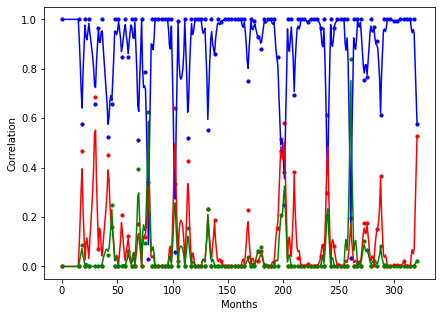

In [84]:
# Calculate smoothing
time_smoothed = np.linspace(0,max(time_months),max(time_months)+50)
S1_smoothed = np.zeros(len(time_smoothed))
S2_smoothed = np.zeros(len(time_smoothed))
S3_smoothed = np.zeros(len(time_smoothed))

for i,t in enumerate(time_smoothed):
    S1_smoothed[i] = smoothing(t,time_months,State1)
    S2_smoothed[i] = smoothing(t,time_months,State2)
    S3_smoothed[i] = smoothing(t,time_months,State3)


# Plot all together
plt.figure(figsize=(7,5))
plt.scatter(time_months,State1,color="blue",s=10)
plt.plot(time_smoothed,S1_smoothed,color="blue")

plt.scatter(time_months,State2,color="red",s=10)
plt.plot(time_smoothed,S2_smoothed,color="red")

plt.scatter(time_months,State3,color="green",s=10)
plt.plot(time_smoothed,S3_smoothed,color="green")
#plt.plot(time_months,State1,color="blue")
#plt.plot(time_months,State2,color="red")
#plt.plot(time_months,State3,color="green")
plt.xlabel("Months")
plt.ylabel("Correlation")
plt.show()

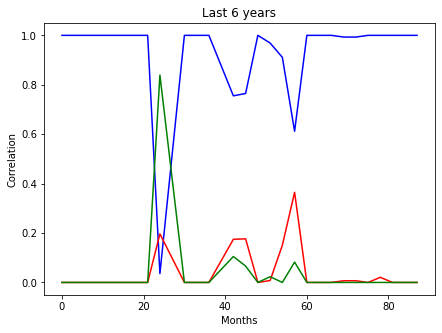

In [283]:
# Look at the most recent 6 years to see short term trends (last 24 data points)
plt.figure(figsize=(7,5))
# plt.scatter(time_months,State1,color="blue",s=10)
# plt.scatter(time_months,State2,color="red",s=10)
# plt.scatter(time_months,State3,color="green",s=10)
plt.plot(time_months[0:24],State1[-25:-1],color="blue")
plt.plot(time_months[0:24],State2[-25:-1],color="red")
plt.plot(time_months[0:24],State3[-25:-1],color="green")
plt.xlabel("Months")
plt.ylabel("Correlation")
plt.title("Last 6 years")
plt.show()

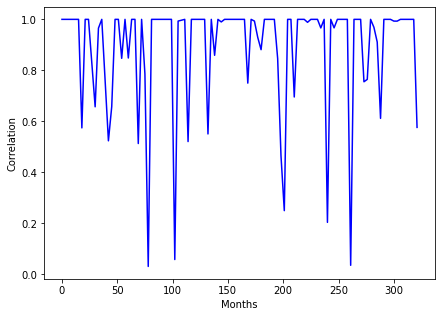

In [284]:
# Plot State 1
plt.figure(figsize=(7,5))
plt.plot(time_months,State1,color="blue")
plt.xlabel("Months")
plt.ylabel("Correlation")
plt.show()

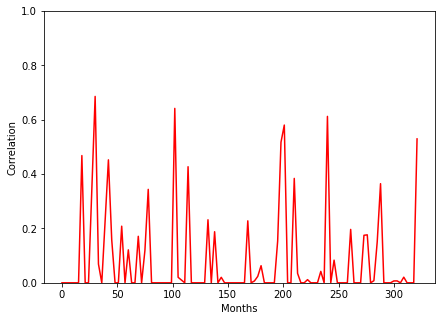

In [285]:
# Plot state 2
plt.figure(figsize=(7,5))
plt.plot(time_months,State2,color="red")
plt.xlabel("Months")
plt.ylim(0,1)
plt.ylabel("Correlation")
plt.show()

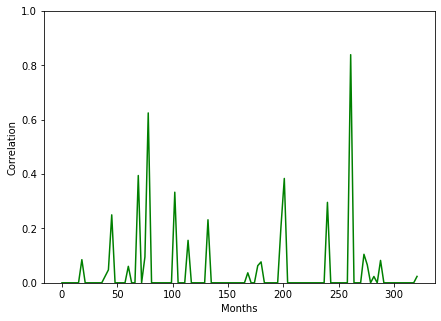

In [286]:
# Plot State 3
plt.figure(figsize=(7,5))
plt.plot(time_months,State3,color="green")
plt.xlabel("Months")
plt.ylim(0,1)
plt.ylabel("Correlation")
plt.show()

In [287]:
df.FLDNUM.unique()

array(['Havana, IL', 'Onalaska, WI', 'Lake City, MN', 'Bellevue, IA',
       'Jackson, MO', 'Brighton, IL'], dtype=object)

## Havana, IL

In [332]:
pool_sorted = df[df.FLDNUM=="Havana, IL"].copy()
pool_sorted[["DATE","SEASON"]]

,DATE,SEASON
64787,1993-07-12,2
64794,1993-07-12,2
64789,1993-07-12,2
64790,1993-07-12,2
64791,1993-07-12,2
...,...,...
76650,2020-10-22,3
76652,2020-10-22,3
76654,2020-10-22,3
76653,2020-10-22,3


In [289]:
pool_sorted["YEAR"].unique()

array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020], dtype=object)

In [333]:
start_month = pool_sorted["DATE"].iloc[0].month

start_szn = month_toseason[start_month]

# The list of seasons in order to loop through
seasons = [0,0,0,0]

for i in range(4):
    s = ((start_szn-1+i)%4)+1
    seasons[i] = s

# Used on X axis for plot
time_months = []

# Lists for proportions of points in each state
State1 = []
State2 = []
State3 = []

time = 0

for year in pool_sorted["YEAR"].unique():
    for season in seasons:
        snap_df = pool_sorted[(pool_sorted["YEAR"]==year) & (pool_sorted["SEASON"]==season)]
        
        # If there is no data in this year and season, skip it
        if snap_df.shape[0] == 0:
            time += 3
            print("No data for ",year," ",season)
            continue

        # Check which states these points are in
        S1 = snap_df["State 1"].sum()
        S2 = snap_df["State 2"].sum()
        S3 = snap_df["State 3"].sum()
                
        #print("S3 ",S3," S2",S2," S1 ",S1," snap size ",snap_df.shape[0])
        
        # Find the ratio of the points in this "snapshot" that are in each state
        State1.append(float(S1/snap_df.shape[0]))
        State2.append(float(S2/snap_df.shape[0]))
        State3.append(float(S3/snap_df.shape[0]))
        
            
        time_months.append(time)
    
        #curtime = curtime+pd.DateOffset(months=3)
        time+=3

No data for  1993   4
No data for  1993   1
No data for  1994   3
No data for  1996   4
No data for  2002   3
No data for  2012   1
No data for  2020   1


### Look at correlation function plot

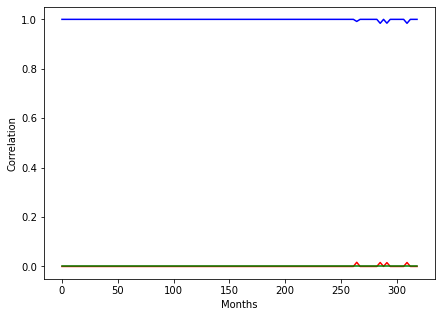

In [334]:
# Plot all together
plt.figure(figsize=(7,5))
# plt.scatter(time_months,State1,color="blue",s=10)
# plt.scatter(time_months,State2,color="red",s=10)
# plt.scatter(time_months,State3,color="green",s=10)
plt.plot(time_months,State1,color="blue")
plt.plot(time_months,State2,color="red")
plt.plot(time_months,State3,color="green")
plt.xlabel("Months")
plt.ylabel("Correlation")
plt.show()

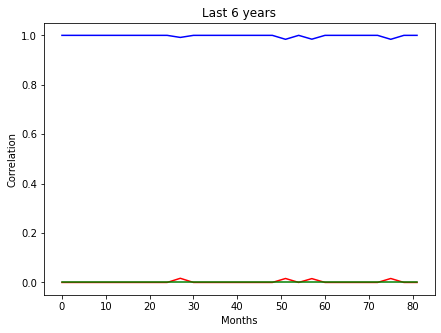

In [292]:
# Look at the most recent 5 years to see short term trends (last 24 data points)
plt.figure(figsize=(7,5))
# plt.scatter(time_months,State1,color="blue",s=10)
# plt.scatter(time_months,State2,color="red",s=10)
# plt.scatter(time_months,State3,color="green",s=10)
plt.plot(time_months[0:24],State1[-25:-1],color="blue")
plt.plot(time_months[0:24],State2[-25:-1],color="red")
plt.plot(time_months[0:24],State3[-25:-1],color="green")
plt.xlabel("Months")
plt.ylabel("Correlation")
plt.title("Last 6 years")
plt.show()

In [293]:
df.FLDNUM.unique()

array(['Havana, IL', 'Onalaska, WI', 'Lake City, MN', 'Bellevue, IA',
       'Jackson, MO', 'Brighton, IL'], dtype=object)

## Onalaska, WI

In [294]:
pool_sorted = df[df.FLDNUM=="Onalaska, WI"].copy()
pool_sorted[["DATE","SEASON"]]

,DATE,SEASON
12794,1993-07-19,2
12793,1993-07-19,2
12802,1993-07-19,2
12795,1993-07-19,2
12796,1993-07-19,2
...,...,...
26728,2020-10-23,3
26727,2020-10-23,3
26722,2020-10-23,3
26725,2020-10-23,3


In [295]:
pool_sorted["YEAR"].unique()

array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020], dtype=object)

In [296]:
start_month = pool_sorted["DATE"].iloc[0].month

start_szn = month_toseason[start_month]

# The list of seasons in order to loop through
seasons = [0,0,0,0]

for i in range(4):
    s = ((start_szn-1+i)%4)+1
    seasons[i] = s

# Used on X axis for plot
time_months = []

# Lists for proportions of points in each state
State1 = []
State2 = []
State3 = []

time = 0

for year in pool_sorted["YEAR"].unique():
    for season in seasons:
        snap_df = pool_sorted[(pool_sorted["YEAR"]==year) & (pool_sorted["SEASON"]==season)]
        
        # If there is no data in this year and season, skip it
        if snap_df.shape[0] == 0:
            time += 3
            print("No data for ",year," ",season)
            continue

        # Check which states these points are in
        S1 = snap_df["State 1"].sum()
        S2 = snap_df["State 2"].sum()
        S3 = snap_df["State 3"].sum()
                
        #print("S3 ",S3," S2",S2," S1 ",S1," snap size ",snap_df.shape[0])
        
        # Find the ratio of the points in this "snapshot" that are in each state
        State1.append(float(S1/snap_df.shape[0]))
        State2.append(float(S2/snap_df.shape[0]))
        State3.append(float(S3/snap_df.shape[0]))
        
            
        time_months.append(time)
    
        #curtime = curtime+pd.DateOffset(months=3)
        time+=3

No data for  1993   4
No data for  1993   1
No data for  1994   3
No data for  1996   4
No data for  2002   3
No data for  2020   1


### Look at correlation function plot

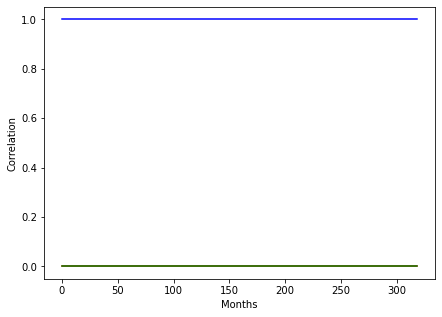

In [297]:
# Plot all together
plt.figure(figsize=(7,5))
# plt.scatter(time_months,State1,color="blue",s=10)
# plt.scatter(time_months,State2,color="red",s=10)
# plt.scatter(time_months,State3,color="green",s=10)
plt.plot(time_months,State1,color="blue")
plt.plot(time_months,State2,color="red")
plt.plot(time_months,State3,color="green")
plt.xlabel("Months")
plt.ylabel("Correlation")
plt.show()

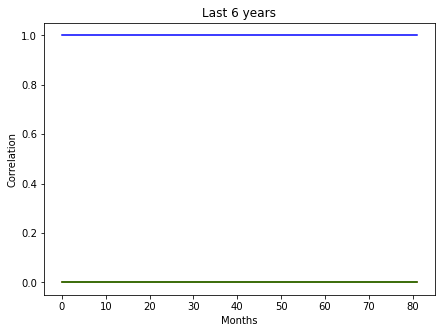

In [298]:
# Look at the most recent 6 years to see short term trends (last 24 data points)
plt.figure(figsize=(7,5))
# plt.scatter(time_months,State1,color="blue",s=10)
# plt.scatter(time_months,State2,color="red",s=10)
# plt.scatter(time_months,State3,color="green",s=10)
plt.plot(time_months[0:24],State1[-25:-1],color="blue")
plt.plot(time_months[0:24],State2[-25:-1],color="red")
plt.plot(time_months[0:24],State3[-25:-1],color="green")
plt.xlabel("Months")
plt.ylabel("Correlation")
plt.title("Last 6 years")
plt.show()

## Lake City, MN

In [299]:
df.FLDNUM.unique()

array(['Havana, IL', 'Onalaska, WI', 'Lake City, MN', 'Bellevue, IA',
       'Jackson, MO', 'Brighton, IL'], dtype=object)

In [300]:
pool_sorted = df[df.FLDNUM=="Lake City, MN"].copy()
pool_sorted[["DATE","SEASON"]]

,DATE,SEASON
0,1993-07-26,2
18,1993-07-26,2
22,1993-07-26,2
21,1993-07-26,2
20,1993-07-26,2
...,...,...
12788,2020-10-16,3
12789,2020-10-16,3
12790,2020-10-16,3
12791,2020-10-16,3


In [301]:
pool_sorted["YEAR"].unique()

array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020], dtype=object)

In [302]:
start_month = pool_sorted["DATE"].iloc[0].month

start_szn = month_toseason[start_month]

# The list of seasons in order to loop through
seasons = [0,0,0,0]

for i in range(4):
    s = ((start_szn-1+i)%4)+1
    seasons[i] = s

# Used on X axis for plot
time_months = []

# Lists for proportions of points in each state
State1 = []
State2 = []
State3 = []

time = 0

for year in pool_sorted["YEAR"].unique():
    for season in seasons:
        snap_df = pool_sorted[(pool_sorted["YEAR"]==year) & (pool_sorted["SEASON"]==season)]
        
        # If there is no data in this year and season, skip it
        if snap_df.shape[0] == 0:
            time += 3
            print("No data for ",year," ",season)
            continue

        # Check which states these points are in
        S1 = snap_df["State 1"].sum()
        S2 = snap_df["State 2"].sum()
        S3 = snap_df["State 3"].sum()
                
        #print("S3 ",S3," S2",S2," S1 ",S1)
        
        # Find the ratio of the points in this "snapshot" that are in each state
        State1.append(float(S1/snap_df.shape[0]))
        State2.append(float(S2/snap_df.shape[0]))
        State3.append(float(S3/snap_df.shape[0]))
        
            
        time_months.append(time)
    
        #curtime = curtime+pd.DateOffset(months=3)
        time+=3

No data for  1993   4
No data for  1993   1
No data for  1994   3
No data for  1996   4
No data for  2002   3
No data for  2020   1


### Look at correlation function plot

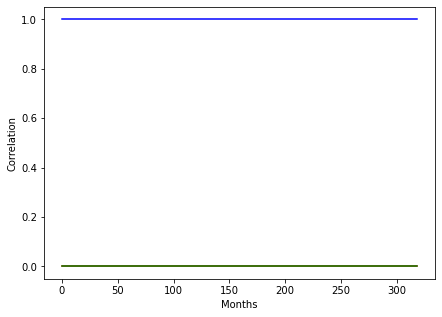

In [303]:
# Plot all together
plt.figure(figsize=(7,5))
# plt.scatter(time_months,State1,color="blue",s=10)
# plt.scatter(time_months,State2,color="red",s=10)
# plt.scatter(time_months,State3,color="green",s=10)
plt.plot(time_months,State1,color="blue")
plt.plot(time_months,State2,color="red")
plt.plot(time_months,State3,color="green")
plt.xlabel("Months")
plt.ylabel("Correlation")
plt.show()

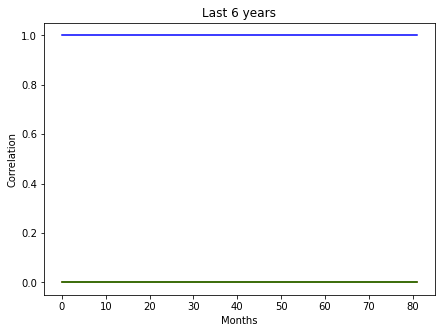

In [304]:
# Look at the most recent 6 years to see short term trends (last 24 data points)
plt.figure(figsize=(7,5))
# plt.scatter(time_months,State1,color="blue",s=10)
# plt.scatter(time_months,State2,color="red",s=10)
# plt.scatter(time_months,State3,color="green",s=10)
plt.plot(time_months[0:24],State1[-25:-1],color="blue")
plt.plot(time_months[0:24],State2[-25:-1],color="red")
plt.plot(time_months[0:24],State3[-25:-1],color="green")
plt.xlabel("Months")
plt.ylabel("Correlation")
plt.title("Last 6 years")
plt.show()

## Bellevue, IA

In [305]:
df.FLDNUM.unique()

array(['Havana, IL', 'Onalaska, WI', 'Lake City, MN', 'Bellevue, IA',
       'Jackson, MO', 'Brighton, IL'], dtype=object)

In [306]:
pool_sorted = df[df.FLDNUM=="Bellevue, IA"].copy()
pool_sorted[["DATE","SEASON"]]

,DATE,SEASON
26745,1993-08-02,2
26743,1993-08-02,2
26742,1993-08-02,2
26741,1993-08-02,2
26740,1993-08-02,2
...,...,...
41447,2020-10-20,3
41448,2020-10-20,3
41449,2020-10-20,3
41450,2020-10-20,3


In [307]:
pool_sorted["YEAR"].unique()

array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020], dtype=object)

In [308]:
start_month = pool_sorted["DATE"].iloc[0].month

start_szn = month_toseason[start_month]

# The list of seasons in order to loop through
seasons = [0,0,0,0]

for i in range(4):
    s = ((start_szn-1+i)%4)+1
    seasons[i] = s

# Used on X axis for plot
time_months = []

# Lists for proportions of points in each state
State1 = []
State2 = []
State3 = []

time = 0

for year in pool_sorted["YEAR"].unique():
    for season in seasons:
        snap_df = pool_sorted[(pool_sorted["YEAR"]==year) & (pool_sorted["SEASON"]==season)]
        
        # If there is no data in this year and season, skip it
        if snap_df.shape[0] == 0:
            time += 3
            print("No data for ",year," ",season)
            continue

        # Check which states these points are in
        S1 = snap_df["State 1"].sum()
        S2 = snap_df["State 2"].sum()
        S3 = snap_df["State 3"].sum()
                
        #print("S3 ",S3," S2",S2," S1 ",S1)
        
        # Find the ratio of the points in this "snapshot" that are in each state
        State1.append(float(S1/snap_df.shape[0]))
        State2.append(float(S2/snap_df.shape[0]))
        State3.append(float(S3/snap_df.shape[0]))
        
            
        time_months.append(time)
    
        #curtime = curtime+pd.DateOffset(months=3)
        time+=3

No data for  1993   4
No data for  1993   1
No data for  1994   3
No data for  1996   4
No data for  2002   3


### Look at correlation function plot

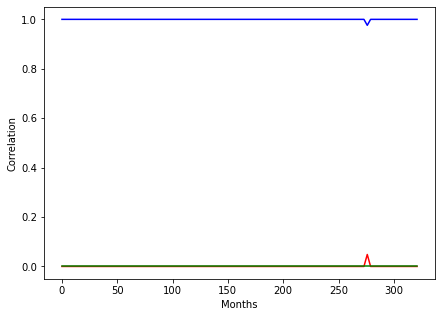

In [309]:
# Plot all together
plt.figure(figsize=(7,5))
# plt.scatter(time_months,State1,color="blue",s=10)
# plt.scatter(time_months,State2,color="red",s=10)
# plt.scatter(time_months,State3,color="green",s=10)
plt.plot(time_months,State1,color="blue")
plt.plot(time_months,State2,color="red")
plt.plot(time_months,State3,color="green")
plt.xlabel("Months")
plt.ylabel("Correlation")
plt.show()

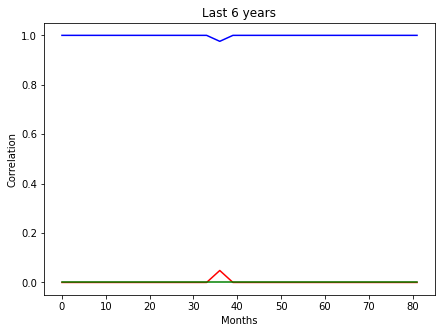

In [310]:
# Look at the most recent 6 years to see short term trends (last 24 data points)
plt.figure(figsize=(7,5))
# plt.scatter(time_months,State1,color="blue",s=10)
# plt.scatter(time_months,State2,color="red",s=10)
# plt.scatter(time_months,State3,color="green",s=10)
plt.plot(time_months[0:24],State1[-25:-1],color="blue")
plt.plot(time_months[0:24],State2[-25:-1],color="red")
plt.plot(time_months[0:24],State3[-25:-1],color="green")
plt.xlabel("Months")
plt.ylabel("Correlation")
plt.title("Last 6 years")
plt.show()

## Brighton, IL

In [311]:
df.FLDNUM.unique()

array(['Havana, IL', 'Onalaska, WI', 'Lake City, MN', 'Bellevue, IA',
       'Jackson, MO', 'Brighton, IL'], dtype=object)

In [312]:
pool_sorted = df[df.FLDNUM=="Brighton, IL"].copy()
pool_sorted[["DATE","SEASON"]]

,DATE,SEASON
41473,1993-10-19,3
41472,1993-10-19,3
41471,1993-10-19,3
41470,1993-10-19,3
41474,1993-10-19,3
...,...,...
52341,2020-10-27,3
52340,2020-10-27,3
52339,2020-10-27,3
52342,2020-10-27,3


In [313]:
pool_sorted["YEAR"].unique()

array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020], dtype=object)

In [314]:
start_month = pool_sorted["DATE"].iloc[0].month

start_szn = month_toseason[start_month]

# The list of seasons in order to loop through
seasons = [0,0,0,0]

for i in range(4):
    s = ((start_szn-1+i)%4)+1
    seasons[i] = s

# Used on X axis for plot
time_months = []

# Lists for proportions of points in each state
State1 = []
State2 = []
State3 = []

time = 0

for year in pool_sorted["YEAR"].unique():
    for season in seasons:
        snap_df = pool_sorted[(pool_sorted["YEAR"]==year) & (pool_sorted["SEASON"]==season)]
        
        # If there is no data in this year and season, skip it
        if snap_df.shape[0] == 0:
            time += 3
            print("No data for ",year," ",season)
            continue

        # Check which states these points are in
        S1 = snap_df["State 1"].sum()
        S2 = snap_df["State 2"].sum()
        S3 = snap_df["State 3"].sum()
                
        #print("S3 ",S3," S2",S2," S1 ",S1)
        
        # Find the ratio of the points in this "snapshot" that are in each state
        State1.append(float(S1/snap_df.shape[0]))
        State2.append(float(S2/snap_df.shape[0]))
        State3.append(float(S3/snap_df.shape[0]))
        
            
        time_months.append(time)
    
        #curtime = curtime+pd.DateOffset(months=3)
        time+=3

No data for  1993   4
No data for  1993   1
No data for  1993   2
No data for  1996   4
No data for  2002   3
No data for  2020   1


### Look at correlation function plot

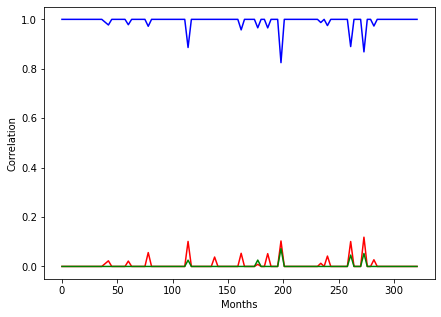

In [315]:
# Plot all together
plt.figure(figsize=(7,5))
# plt.scatter(time_months,State1,color="blue",s=10)
# plt.scatter(time_months,State2,color="red",s=10)
# plt.scatter(time_months,State3,color="green",s=10)
plt.plot(time_months,State1,color="blue")
plt.plot(time_months,State2,color="red")
plt.plot(time_months,State3,color="green")
plt.xlabel("Months")
plt.ylabel("Correlation")
plt.show()

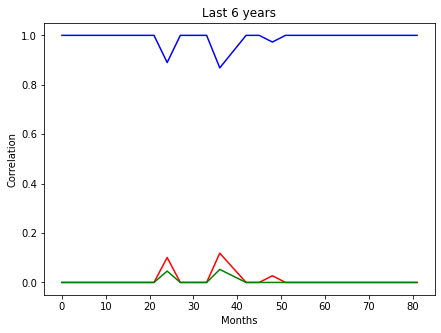

In [316]:
# Look at the most recent 6 years to see short term trends (last 24 data points)
plt.figure(figsize=(7,5))
# plt.scatter(time_months,State1,color="blue",s=10)
# plt.scatter(time_months,State2,color="red",s=10)
# plt.scatter(time_months,State3,color="green",s=10)
plt.plot(time_months[0:24],State1[-25:-1],color="blue")
plt.plot(time_months[0:24],State2[-25:-1],color="red")
plt.plot(time_months[0:24],State3[-25:-1],color="green")
plt.xlabel("Months")
plt.ylabel("Correlation")
plt.title("Last 6 years")
plt.show()

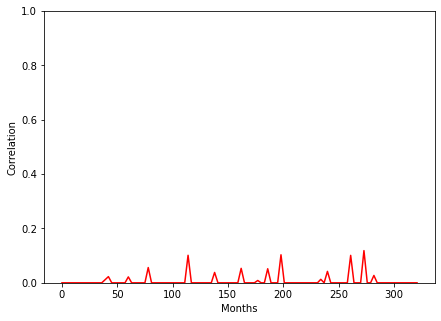

In [317]:
# Plot state 2
plt.figure(figsize=(7,5))
plt.plot(time_months,State2,color="red")
plt.xlabel("Months")
plt.ylim(0,1)
plt.ylabel("Correlation")
plt.show()

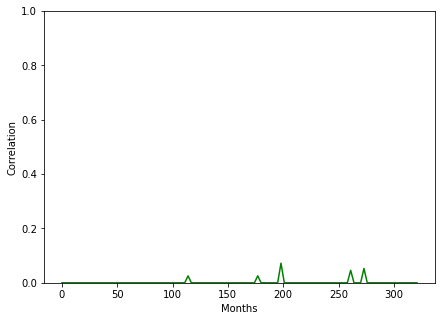

In [318]:
# Plot State 3
plt.figure(figsize=(7,5))
plt.plot(time_months,State3,color="green")
plt.xlabel("Months")
plt.ylim(0,1)
plt.ylabel("Correlation")
plt.show()

#### Possible error in appending states to dataframe?
There are datapoints that are not assigned to any state, possibly these points were lost to noise

In [171]:
unique = set()
for node in scomplex['nodes']:
    unique.update(scomplex['nodes'][node])
num_unique = len(unique)
df.shape[0]-num_unique

4824

In [272]:
df.loc[unique]

,WDP,SECCHI,TEMP,DO,TURB,VEL,TP,TN,SS,CHLcal,...,VEL_color,TP_color,TN_color,SS_color,CHLcal_color,State 3,State 2,State 1,STATE,STATE_color
0,-0.018088,-0.046512,0.572414,-0.72093,0.210526,0.576923,0.481481,0.918033,0.361752,-0.294693,...,0.576923,0.481481,0.918033,0.361752,-0.294693,0,0,1,0.333333,0.333333
1,1.5323,0.0,0.572414,-0.72093,0.210526,1.0,0.488889,1.547131,0.262323,-0.342123,...,1.0,0.488889,1.547131,0.262323,-0.342123,0,0,1,0.333333,0.333333
2,0.524548,0.023256,0.565517,-0.790698,0.105263,0.884615,0.422222,0.918033,0.18828,-0.323151,...,0.884615,0.422222,0.918033,0.18828,-0.323151,0,0,1,0.333333,0.333333
3,1.764858,-0.093023,0.565517,-0.767442,0.210526,0.942308,0.362963,1.124317,0.173472,-0.332637,...,0.942308,0.362963,1.124317,0.173472,-0.332637,0,0,1,0.333333,0.333333
4,1.144703,0.069767,0.572414,-0.72093,0.342105,0.923077,0.548148,0.969262,0.482336,-0.291531,...,0.923077,0.548148,0.969262,0.482336,-0.291531,0,0,1,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76663,-0.328165,-0.627907,0.124138,-0.627907,1.657895,-0.307692,1.525926,-0.58265,1.16776,2.368874,...,-0.307692,1.525926,-0.58265,1.16776,2.368874,0,0,1,0.333333,0.333333
76665,-0.44186,-0.325581,-0.431034,0.186047,0.605263,-0.384615,1.525926,-0.596311,0.186165,0.620584,...,-0.384615,1.525926,-0.596311,0.186165,0.620584,0,0,1,0.333333,0.333333
76666,-0.447028,-0.372093,-0.365517,0.22093,0.605263,-0.384615,1.474074,-0.711066,0.105775,0.89303,...,-0.384615,1.474074,-0.711066,0.105775,0.89303,0,0,1,0.333333,0.333333
76667,-0.421189,-0.372093,-0.441379,0.127907,0.684211,-0.384615,1.474074,-0.61612,0.228475,0.644173,...,-0.384615,1.474074,-0.61612,0.228475,0.644173,0,0,1,0.333333,0.333333


In [159]:
odd = pool_sorted
no_state = odd[(odd["State 1"]==0)&(odd["State 2"]==0)&(odd["State 3"]==0)]
no_state

,WDP,SECCHI,TEMP,DO,TURB,VEL,TP,TN,SS,CHLcal,...,VEL_color,TP_color,TN_color,SS_color,CHLcal_color,State 3,State 2,State 1,STATE,STATE_color
65028,0.21447,-0.372093,0.303448,0.302326,0.947368,-0.307692,0.577778,2.24112,0.640999,3.737433,...,-0.307692,0.577778,2.24112,0.640999,3.649614,0,0,0,0.0,0.0
65044,1.299742,-0.511628,0.262069,0.023256,1.605263,1.076923,0.296296,1.862705,1.341231,1.537455,...,1.076923,0.296296,1.862705,1.341231,1.537455,0,0,0,0.0,0.0
65136,0.834625,-0.372093,0.855172,-0.651163,1.131579,1.346154,0.711111,5.854508,1.214301,0.705855,...,1.346154,0.711111,3.521175,1.214301,0.705855,0,0,0,0.0,0.0
65198,-0.496124,-0.511628,0.855172,-0.953488,1.921053,-0.096154,0.925926,0.446038,2.593611,0.684424,...,-0.096154,0.925926,0.446038,2.593611,0.684424,0,0,0,0.0,0.0
65197,-0.483204,-0.55814,0.848276,-0.767442,3.157895,-0.153846,1.4,0.246585,2.563994,1.008565,...,-0.153846,1.4,0.246585,2.563994,1.008565,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76619,2.540052,-0.348837,-0.282759,0.023256,1.157895,-0.384615,2.185185,0.174863,0.509202,0.74462,...,-0.384615,2.185185,0.174863,0.509202,0.74462,0,0,0,0.0,0.0
76617,-0.488372,-0.511628,-0.351724,0.302326,1.710526,-0.384615,4.362963,-1.05123,0.775756,-0.170522,...,-0.384615,3.62963,-1.05123,0.775756,-0.170522,0,0,0,0.0,0.0
76623,-0.444444,-0.627907,-0.268966,0.255814,2.236842,-0.384615,2.637037,-1.093579,2.618997,0.088242,...,-0.384615,2.637037,-1.093579,2.618997,0.088242,0,0,0,0.0,0.0
76613,-0.550388,-0.651163,-0.358621,0.139535,3.026316,-0.384615,2.511111,-1.098361,2.136662,0.574214,...,-0.384615,2.511111,-1.098361,2.136662,0.574214,0,0,0,0.0,0.0


In [186]:
# This is checking to see if the points not assigned to a state exist within the scomplex
mystery_nodes = set()
for i in no_state.index:
    for node in scomplex["nodes"]:
        if i in scomplex['nodes'][node]:
            foundnode = node
            mystery_nodes.add(foundnode)
            print("found node: ",foundnode)
            break
        
    for state in scomplex['states']:
        if foundnode in scomplex['states'][state]:
            print(i," in state ",state)
            break

found node:  cube413_cluster0
found node:  cube413_cluster0
found node:  cube203_cluster0
found node:  cube236_cluster0
found node:  cube269_cluster0
found node:  cube203_cluster0
found node:  cube203_cluster0
found node:  cube413_cluster0
found node:  cube413_cluster0
found node:  cube203_cluster0
found node:  cube413_cluster0
found node:  cube413_cluster0
found node:  cube413_cluster0
found node:  cube203_cluster0
found node:  cube413_cluster0
found node:  cube413_cluster0
found node:  cube413_cluster0
found node:  cube236_cluster0
found node:  cube203_cluster0
found node:  cube269_cluster0
found node:  cube203_cluster0
found node:  cube236_cluster0
found node:  cube203_cluster0
found node:  cube236_cluster0
found node:  cube413_cluster0
found node:  cube269_cluster0
found node:  cube269_cluster0
found node:  cube236_cluster0
found node:  cube269_cluster0
found node:  cube269_cluster0
found node:  cube269_cluster0
found node:  cube269_cluster0
found node:  cube269_cluster0
found node

In [187]:
mystery_nodes

{'cube203_cluster0',
 'cube236_cluster0',
 'cube269_cluster0',
 'cube413_cluster0'}

So these nodes are not in any state? How could this be?

I realized these nodes are not part of the main simplicial complex. I should remove these datapoints at the beginning.